# Problem 1: Kalman Filter for Landmark Localization

In [12]:
pip install matplotlib==3.7.0

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

np.random.seed(123456)

## Simulation Setup

In [14]:
# NOTE: We are not estimating the state of the robot in this problem.
# Instead, we are estimating the state of landmarks assuming knowledge
# of the robot state. Thus, please do not confuse the robot_motion_model
# with the dynamics model that should be used in the Kalman Filter.
def robot_motion_model(
    xr: np.ndarray,
    v: float,
    omega: float,
    dt: float,
) -> np.ndarray:
    """Robot motion model.

    Args:
        xr (np.ndarray): Robot state.
        v (float): Linear velocity command.
        omega (float): Angular velocity command.

    Returns:
        np.ndarray: Next robot state.
    """
    return np.array([xr[0] + dt * v * np.cos(xr[2]),
                     xr[1] + dt * v * np.sin(xr[2]),
                     xr[2] + dt * omega])


def robot_commands(t: float) -> np.ndarray:
    """Robot linear and angular velocity commands.

    Args:
        t (float): Current timestep.

    Returns:
        np.ndarray: Robot linear and angular velocity commands.
    """
    return np.array([1, np.sin(t)])

In [15]:
# Timesteps.
dt = 0.1
ti = 0
tf = 15
time = np.arange(ti, tf+dt, dt)

# Ground-truth landmark positions.
# NOTE: We are estimating the state of the landmarks in this problem.
xm = np.array([
    [0, 0],
    [2, 8],
    [8, 2],
    [10, 10]
], dtype=float)

# Ground-truth robot states.
# NOTE: We are not estimating the state of the robot in this problem.
xr = np.zeros((3, len(time)))
xr[:, 0] = np.array([1, 1, 0])
for i, t in enumerate(time[1:], 1):
    xr[:, i] = robot_motion_model(xr[:, i-1], *robot_commands(t), dt)

## Kalman Filter Setup

In [16]:
# Ground-truth states (simulated).
x = np.zeros((8, len(time)))
x[:, 0] = xm.flatten()

# Estimated states (Kalman Filter).
mu_kf = np.zeros((8, len(time)))
cov_kf = [np.eye(8) for _ in range(len(time))]

# Initial state and state covariance estimate.
init_mu_std = 0.1
mu_kf[:, 0] = xm.flatten() + init_mu_std * np.random.randn(8)
cov_kf[0] = np.eye(8)
cov_kf[0] = init_mu_std * np.eye(8)

# Process and observation noise.
Q = 0.0 * np.eye(8)  # Landmarks are stationary, assume zero process noise.
R = 0.25 * np.eye(8)  # Measurements contain noise, assume observation noise.

## Kalman Filter Implementation

In [17]:
####################### Code starts here #######################
# NOTE: What are the state transition and observation matrices?
A = np.identity(8, dtype = float)
C = np.identity(8, dtype = float)
####################### Code ends here #######################

for i in range(1, len(time)):
    ### Simulation.

    # True landmark dynamics
    x[:, i] = A @ x[:, i-1]

    # True received measurement
    v_noise = np.random.multivariate_normal(np.zeros((8,)), R)
    y = C @ x[:, i] + v_noise

    ### Estimation.

    ####################### Code starts here #######################
    # NOTE: Implement Kalman Filtering Predict and Update steps.
    # Write resulting means to mu_kf.
    # Write resulting covariances to cov_kf.
    mu_kf_pred = A @ mu_kf[:, i-1]
    cov_kf_pred = A @ cov_kf[i-1] @ A.T + Q
    K_t = cov_kf_pred @ C.T @ np.linalg.inv(C @ cov_kf_pred @ C.T + R)
    mu_kf[:, i] = mu_kf_pred + K_t @ (y - C @ mu_kf_pred)
    cov_kf[i] = (np.identity(8) - K_t @ C) @ cov_kf_pred
    ####################### Code ends here #######################

## Plot Results

In [18]:
def plot_error_ellipse(ax, mean, cov):
    # Calculate the error ellipse parameters
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))

    # Compute the radius of the ellipse to correspond to the desired confidence level
    chi2_val = 2.4477  # Corresponds to 95% conf. interval
    width, height = 2 * chi2_val * np.sqrt(eigenvalues)

    # Draw the ellipse
    ellipse = patches.Ellipse(mean, width, height, angle, edgecolor='red', fc='None', lw=2)
    ax.add_patch(ellipse)

### Plot Mean Estimates of 2D Landmark Positions

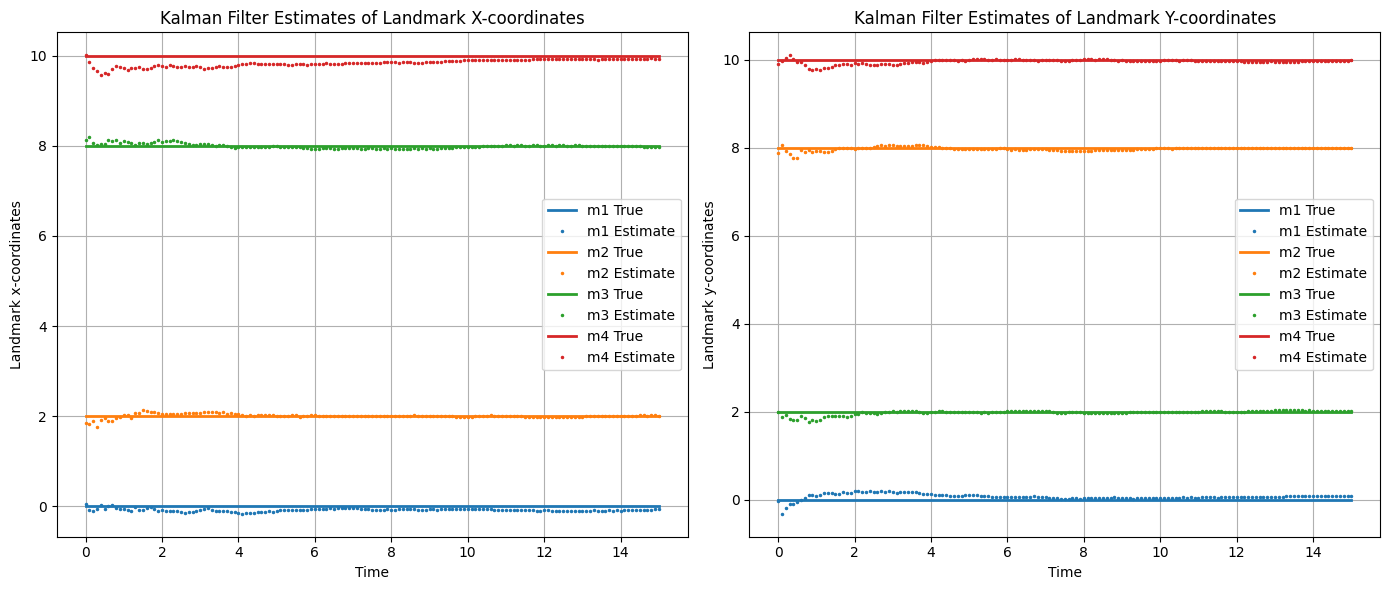

In [19]:
plt.figure(figsize=(14, 6))

# Subplot for x positions.
plt.subplot(121)
plt.title('Kalman Filter Estimates of Landmark X-coordinates')
plt.plot(time, x[0, :], linewidth=2, label='m1 True', color='C0')
plt.plot(time, mu_kf[0, :], '.', markersize=3, label='m1 Estimate', color='C0')
plt.plot(time, x[2, :], linewidth=2, label='m2 True', color='C1')
plt.plot(time, mu_kf[2, :], '.', markersize=3, label='m2 Estimate', color='C1')
plt.plot(time, x[4, :], linewidth=2, label='m3 True', color='C2')
plt.plot(time, mu_kf[4, :], '.', markersize=3, label='m3 Estimate', color='C2')
plt.plot(time, x[6, :], linewidth=2, label='m4 True', color='C3')
plt.plot(time, mu_kf[6, :], '.', markersize=3, label='m4 Estimate', color='C3')
plt.xlabel('Time')
plt.ylabel('Landmark x-coordinates')
plt.legend()
plt.grid(True)

# Subplot for y positions.
plt.subplot(122)
plt.title('Kalman Filter Estimates of Landmark Y-coordinates')
plt.plot(time, x[1, :], linewidth=2, label='m1 True', color='C0')
plt.plot(time, mu_kf[1, :], '.', markersize=3, label='m1 Estimate', color='C0')
plt.plot(time, x[3, :], linewidth=2, label='m2 True', color='C1')
plt.plot(time, mu_kf[3, :], '.', markersize=3, label='m2 Estimate', color='C1')
plt.plot(time, x[5, :], linewidth=2, label='m3 True', color='C2')
plt.plot(time, mu_kf[5, :], '.', markersize=3, label='m3 Estimate', color='C2')
plt.plot(time, x[7, :], linewidth=2, label='m4 True', color='C3')
plt.plot(time, mu_kf[7, :], '.', markersize=3, label='m4 Estimate', color='C3')
plt.xlabel('Time')
plt.ylabel('Landmark y-coordinates')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Plot Error Ellipses of 2D Landmarks Along Trajectory

<ipython-input-18-655a2c035c6b>:13: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = patches.Ellipse(mean, width, height, angle, edgecolor='red', fc='None', lw=2)


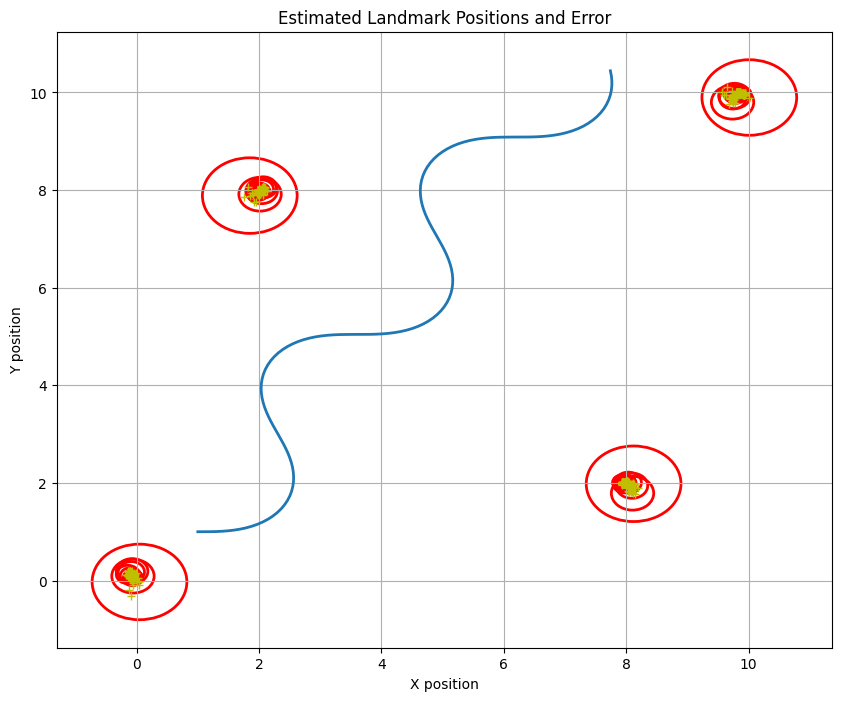

In [20]:
plt.figure(figsize=(10, 8))
plt.title('Estimated Landmark Positions and Error')
plt.plot(xr[0, :], xr[1, :], linewidth=2)
plt.plot(mu_kf[0, :], mu_kf[1, :], 'y+')
plt.plot(mu_kf[2, :], mu_kf[3, :], 'y+')
plt.plot(mu_kf[4, :], mu_kf[5, :], 'y+')
plt.plot(mu_kf[6, :], mu_kf[7, :], 'y+')

for i in range(0, len(time), 10):
    plot_error_ellipse(plt.gca(), mu_kf[0:2, i], cov_kf[i][0:2, 0:2])
    plot_error_ellipse(plt.gca(), mu_kf[2:4, i], cov_kf[i][2:4, 2:4])
    plot_error_ellipse(plt.gca(), mu_kf[4:6, i], cov_kf[i][4:6, 4:6])
    plot_error_ellipse(plt.gca(), mu_kf[6:8, i], cov_kf[i][6:8, 6:8])

plt.xlabel('X position')
plt.ylabel('Y position')
plt.grid(True)

### Plot Trajectory and 2D Landmark Estimates in X-Y Space

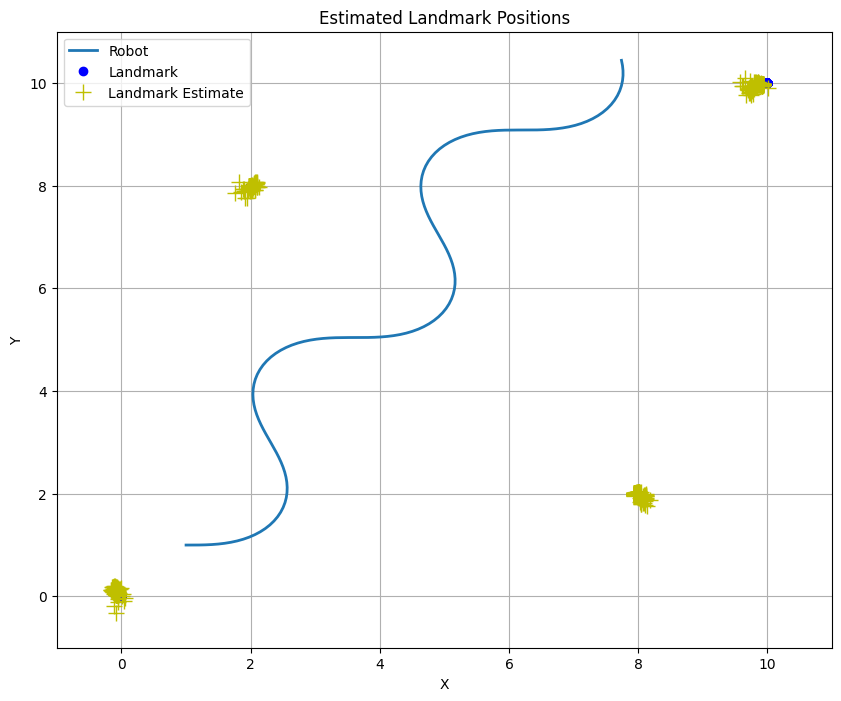

In [21]:
plt.figure(figsize=(10, 8))
plt.title('Estimated Landmark Positions')
plt.plot(xr[0, :], xr[1, :], linewidth=2, label='Robot')
plt.plot(x[0, :], x[1, :], 'b.', markersize=12, label='Landmark')
plt.plot(mu_kf[0, :], mu_kf[1, :], 'y+', markersize=12, label='Landmark Estimate')
plt.plot(x[2, :], x[3, :], 'b.', markersize=12)
plt.plot(mu_kf[2, :], mu_kf[3, :], 'y+', markersize=12)
plt.plot(x[4, :], x[5, :], 'b.', markersize=12)
plt.plot(mu_kf[4, :], mu_kf[5, :], 'y+', markersize=12)
plt.plot(x[6, :], x[7, :], 'b.', markersize=12)
plt.plot(mu_kf[6, :], mu_kf[7, :], 'y+', markersize=12)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.xlim([-1, 11])
plt.ylim([-1, 11])
plt.grid(True)
plt.show()